In [22]:
from scipy import constants
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [30]:
class CanonicalEnsemble:
    """
    Defines a canonical ensemble with partition function Z
    """
    def __init__(self, z):
        """
        CanonicalEnsemble(z)

        Parameters
        ---------------------------
        z: partition function at a given temperature (K)
        """
        self.z = z

    def calc_u(self, temp_1, temp_2, n=100):
        """
        Calculates the internal energy of the system from temp_1 to temp_2 for n points

        Parameters
        ----------------------------
        temp_1 (K): starting temperature
        temp_2 (K): ending temperature
        n: number of datapoints

        Returns
        -----------------------------
        An np.array of calculated internal energies from temp_1 to temp_2 with length n (J)
        """
        temps = np.linspace(temp_1, temp_2, n)
        lnZs = np.log(np.array([self.z(temp) for temp in temps]))
        betas = 1/(constants.k*temps)
        us = -np.gradient(lnZs, betas)
        self.u = us
        return us

    def calc_f(self, temp_1, temp_2, n=100):
        """
        Calculates the free energy of the system from temp_1 to temp_2 for n points

        Parameters
        ----------------------------
        temp_1 (K): starting temperature
        temp_2 (K): ending temperature
        n: number of datapoints

        Returns
        -----------------------------
        An np.array of calculated free energies from temp_1 to temp_2 with length n (J)
        """
        temps = np.linspace(temp_1, temp_2, n)
        lnZs = np.log(np.array([self.z(temp) for temp in temps]))
        fs = -constants.k*temps*lnZs
        self.f = fs
        return fs

    def calc_s(self, temp_1, temp_2, n=100):
        """
        Calculates the entropy of the system from temp_1 to temp_2 for n points

        Parameters
        ----------------------------
        temp_1 (K): starting temperature
        temp_2 (K): ending temperature
        n: number of datapoints

        Returns
        -----------------------------
        An np.array of calculated entropies from temp_1 to temp_2 with length n (J/K)
        """
        temps = np.linspace(temp_1, temp_2, n)
        fs = self.calc_f(temp_1, temp_2, n)
        ss = -np.gradient(fs, temps)
        self.s = ss
        return ss

    def calc_thermo(self, temp_1, temp_2, n=100):
        """
        Calculates the internal energy, free energy and entropy of the system from temp_1 to temp_2 for n points
        Result is stored in attributes u, f and s, respectively.

        Parameters
        ----------------------------
        temp_1 (K): starting temperature
        temp_2 (K): ending temperature
        n: number of datapoints
        """
        self.calc_u(temp_1, temp_2, n)
        self.calc_f(temp_1, temp_2, n)
        self.calc_s(temp_1, temp_2, n)
        self.thermo_df = pd.DataFrame({
            'temperature': np.linspace(temp_1, temp_2, n),
            'internal_energy': self.u,
            'free_energy': self.f,
            'entropy': self.s
        })

In [25]:
def degenerate_partition(temp):
    """
    Calculates the partition function for an isolated Ce^{3+} ion with 14-fold degeneracy

    Returns:
    The partition function
    """
    return 14

isolatedCe = CanonicalEnsemble(degenerate_partition)
isolatedCe.calc_thermo(300, 2000, 100)

In [26]:
def soc_partition(temp):
    """
    Calculates the partition function for a Ce^{3+} ion with spin orbit coupling
    
    Parameters
    -----------------------------
    temp (K): temperature

    Returns:
    The partition function
    """
    e = 0.28*constants.eV # J
    exponent = -e/(constants.k*temp)
    return 6 + 8 * (np.e**exponent)

socCe = CanonicalEnsemble(soc_partition)
socCe.calc_thermo(300, 2000, 100)

In [27]:
def cfs_partition(temp):
    """
    Calculates the partition function for a Ce^{3+} ion with both spin orbit coupling and crystal field splitting
    
    Parameters
    -----------------------------
    temp (K): temperature
    
    Returns:
    The partition function
    """

    # convert eV to J
    def evToJ(ev):
        return ev*constants.eV
    # calculate the exponent
    def calc_exp(energy):
        # energy in eV
        return np.e**(-evToJ(energy) / (constants.k*temp))

    e0 = calc_exp(0)
    e1 = calc_exp(0.12)
    e2 = calc_exp(0.12+0.13)
    e3 = calc_exp(0.12+0.13+0.07)
    e4 = calc_exp(0.12+0.13+0.07+0.14)
    return 4*e0 + 2*e1 + 2*e2 + 4*e3 + 2*e4

cfsCe = CanonicalEnsemble(cfs_partition)
cfsCe.calc_thermo(300, 2000, 100)

In [33]:
combined_df = pd.concat([
    isolatedCe.thermo_df.assign(system='isolated'),
    socCe.thermo_df.assign(system='soc'),
    cfsCe.thermo_df.assign(system='soc and cfs')
], axis=0)
combined_df.to_csv('thermo_properties.csv', index=False)

In [34]:
combined_df

,temperature,internal_energy,free_energy,entropy,system
0,300.000000,0.000000e+00,-1.093084e-20,3.643612e-23,isolated
1,317.171717,-0.000000e+00,-1.155651e-20,3.643612e-23,isolated
2,334.343434,-0.000000e+00,-1.218218e-20,3.643612e-23,isolated
3,351.515152,-2.407412e-35,-1.280785e-20,3.643612e-23,isolated
4,368.686869,-0.000000e+00,-1.343352e-20,3.643612e-23,isolated
...,...,...,...,...,...
95,1931.313131,1.236973e-20,-4.834254e-20,3.143545e-23,soc and cfs
96,1948.484848,1.249749e-20,-4.888291e-20,3.150132e-23,soc and cfs
97,1965.656566,1.262416e-20,-4.942440e-20,3.156605e-23,soc and cfs
98,1982.828283,1.274974e-20,-4.996699e-20,3.162966e-23,soc and cfs


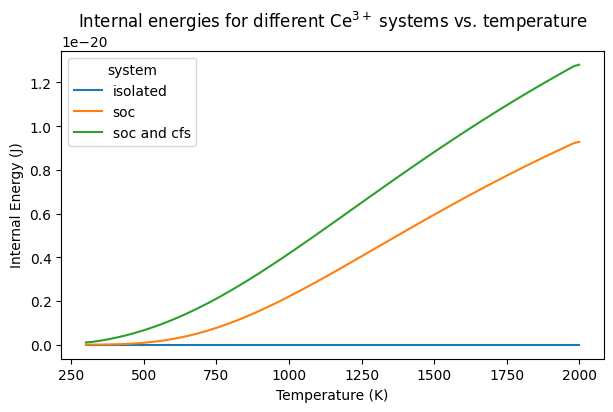

In [38]:
# plot internal energies
fig, ax = plt.subplots()
fig.set_size_inches(7,4)
sns.lineplot(combined_df, x='temperature', y='internal_energy', hue='system', ax=ax)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Internal Energy (J)')
ax.set_title('Internal energies for different Ce$^{3+}$ systems vs. temperature')
fig.savefig('internal_energies.png', dpi=210)

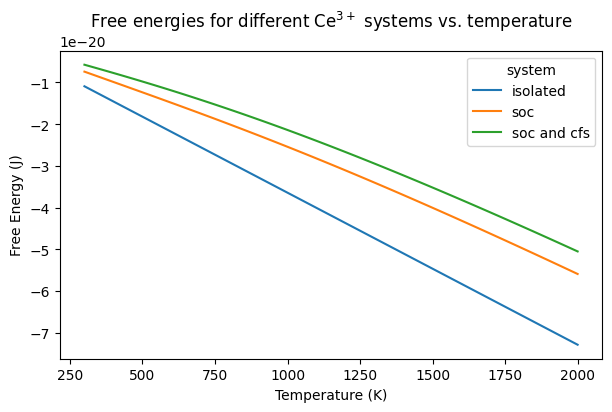

In [39]:
# plot free energies
fig, ax = plt.subplots()
fig.set_size_inches(7,4)
sns.lineplot(combined_df, x='temperature', y='free_energy', hue='system', ax=ax)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Free Energy (J)')
ax.set_title('Free energies for different Ce$^{3+}$ systems vs. temperature')
fig.savefig('free_energies.png', dpi=210)

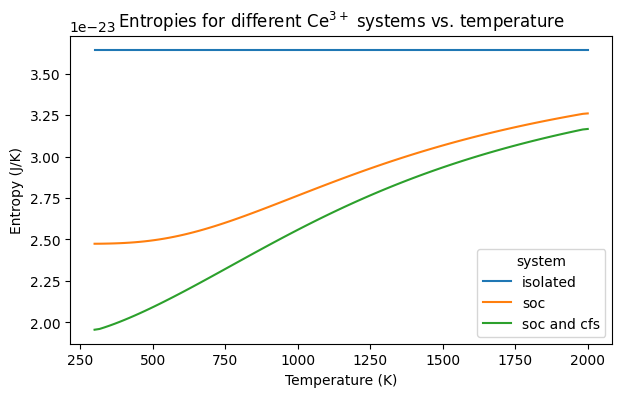

In [40]:
# plot entropies
fig, ax = plt.subplots()
fig.set_size_inches(7,4)
sns.lineplot(combined_df, x='temperature', y='entropy', hue='system', ax=ax)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Entropy (J/K)')
ax.set_title('Entropies for different Ce$^{3+}$ systems vs. temperature')
fig.savefig('entropies.png', dpi=210)